## Certified privacy- and unlearning-safe training on the OCT-MNIST dataset

Run over different privacy and unlearning parameters and plot the results

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import math
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [2]:
results_dir = ".results/"
seed = 2
notebook_id = f"oct_sweep_v2_{seed}"
model_path = ".models/medmnist.ckpt"  # pretrained model path
draft = True  # whether to compute the full suite of results or a quicker reduced version
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Define the nominal config, model and dataloaders

In [79]:
batchsize = 5000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=0.2,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=2.0,
    # dp_sgd_sigma=1.0,
    lr_min=0.001,
    early_stopping=False,
    metadata=f"model={model_path}"
)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

# get dataloaders, train dataloader is a mix of drusen and the "healthy" class
dl_train, _ = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1], balanced=True)
_, dl_test_drusen = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1, 3])
_, dl_test_other = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[2])
_, dl_test_all = oct_mnist.get_dataloaders(batchsize, 1000)

In [75]:
# compute pre-trained model accuracy
pretrain_acc = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)[1]
pretrain_acc_all = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)[1]
pretrain_acc_other = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_other)), model, ct_utils.propagate_conv_layers
)[1]
print(f"Pre-trained accuracy on Drusen: {pretrain_acc:.3g}", file=sys.stderr)
print(f"Pre-trained accuracy on all classes:  {pretrain_acc_all:.3g}", file=sys.stderr)
print(f"Pre-trained accuracy on classes 0, 1, 3:  {pretrain_acc_other:.3g}", file=sys.stderr)

# perform one certified training run with to check the nominal accuracy we get
config = copy.deepcopy(nominal_config)
config.k_private = 1
config.clip_gamma = 2.0
config.dp_sgd_sigma = 0.0
torch.manual_seed(seed)
param_l, param_n, param_u = agt.privacy_certified_training(
    model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
)

# compute the accuracies of the fine-tuned model
finetune_acc = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)[1]
finetune_acc_all = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)[1]
finetune_acc_other = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_other)), model, ct_utils.propagate_conv_layers
)[1]
print(f"Fine-tuned accuracy on Drusen: {finetune_acc:.3g}",file=sys.stderr)
print(f"Fine-tuned accuracy on all classes: {finetune_acc_all:.3g}",file=sys.stderr)
print(f"Fine-tuned accuracy on classes 0, 1, 3: {finetune_acc_other:.3g}", file=sys.stderr)

percent_certified = test_metrics.proportion_certified(
    param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)
print(f"Fine-tuned percent certified on all classes: {percent_certified:.3g}", file=sys.stderr)

del param_l, param_n, param_u
torch.cuda.empty_cache()

Pre-trained accuracy on Drusen: 0.456
Pre-trained accuracy on all classes:  0.835
Pre-trained accuracy on classes 0, 1, 3:  0.961
[AGT] [INFO    ] [03:23:12] =================== Starting Privacy Certified Training ===================
[AGT] [DEBUG   ] [03:23:12] 	Optimizer params: n_epochs=2, learning_rate=0.2, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [03:23:12] 	Learning rate schedule: lr_decay=2.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [03:23:12] 	Privacy parameter: k_private=1
[AGT] [DEBUG   ] [03:23:12] 	Clipping: gamma=2.0, method=clamp
[AGT] [DEBUG   ] [03:23:12] 	Noise: type=gaussian, sigma=0.0
[AGT] [DEBUG   ] [03:23:12] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [03:23:12] Starting epoch 1
[AGT] [DEBUG   ] [03:23:12] Initialising dataloader batchsize to 5000
[AGT] [INFO    ] [03:23:12] Training batch 1: Network eval bounds=(0.46, 0.46, 0.46), W0 Bound=0.0 
[AGT] [INFO    ] [03:23:13] Training batch 2: Network 

### Helper functions to perform the sweep

In [62]:
def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy (on the Drusen class) and percent certified (on the entire test set)
    param_l = [p.to(nominal_config.device) for p in param_l]
    param_n = [p.to(nominal_config.device) for p in param_n]
    param_u = [p.to(nominal_config.device) for p in param_u]
    nominal_accuracy = test_metrics.test_accuracy(
        param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
    )[1]
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
    )
    del param_l, param_n, param_u
    torch.cuda.empty_cache()
    return nominal_accuracy, percent_certified

### Perform the sweep over different gamma and k values

In [63]:
k_unlearning_vals = list(range(0, 2001, 100))
k_private_vals = list(range(0, 201, 10))
clip_gammas_privacy = clip_gammas_unlearning = [0.1, 0.5, 1.0, 2.0, 4.0]

In [64]:
unlearning_results = {}  # the results dictionary will be indexed by results[gamma][k_private]
config = copy.deepcopy(nominal_config)
for gamma in clip_gammas_unlearning:
    config.clip_gamma = gamma
    tmp_results = {}
    for k_unlearn in k_unlearning_vals:
        config.k_unlearn = k_unlearn
        tmp_results[k_unlearn] = run_with_config(config)
    unlearning_results[gamma] = tmp_results

In [65]:
privacy_results = {}  # the results dictionary will be indexed by results[gamma][k_private]

config = copy.deepcopy(nominal_config)
for gamma in clip_gammas_privacy:
    config.clip_gamma = gamma
    tmp_results = {}
    for k_private in k_private_vals:
        config.k_private = k_private
        tmp_results[k_private] = run_with_config(config)
    privacy_results[gamma] = tmp_results
    

[AGT] [INFO    ] [03:12:26] =================== Starting Privacy Certified Training ===================
[AGT] [DEBUG   ] [03:12:26] 	Optimizer params: n_epochs=2, learning_rate=0.2, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [03:12:26] 	Learning rate schedule: lr_decay=2.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [03:12:26] 	Privacy parameter: k_private=120
[AGT] [DEBUG   ] [03:12:26] 	Clipping: gamma=4.0, method=clamp
[AGT] [DEBUG   ] [03:12:26] 	Noise: type=gaussian, sigma=0
[AGT] [DEBUG   ] [03:12:26] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [03:12:26] Starting epoch 1
[AGT] [DEBUG   ] [03:12:26] Initialising dataloader batchsize to 5000
[AGT] [INFO    ] [03:12:26] Training batch 1: Network eval bounds=(0.46, 0.46, 0.46), W0 Bound=0.0 
[AGT] [INFO    ] [03:12:27] Training batch 2: Network eval bounds=(0.04, 0.96, 1   ), W0 Bound=21.8 
[AGT] [INFO    ] [03:12:28] Training batch 3: Network eval bounds=(0   , 0.89, 1   

### Plot the results

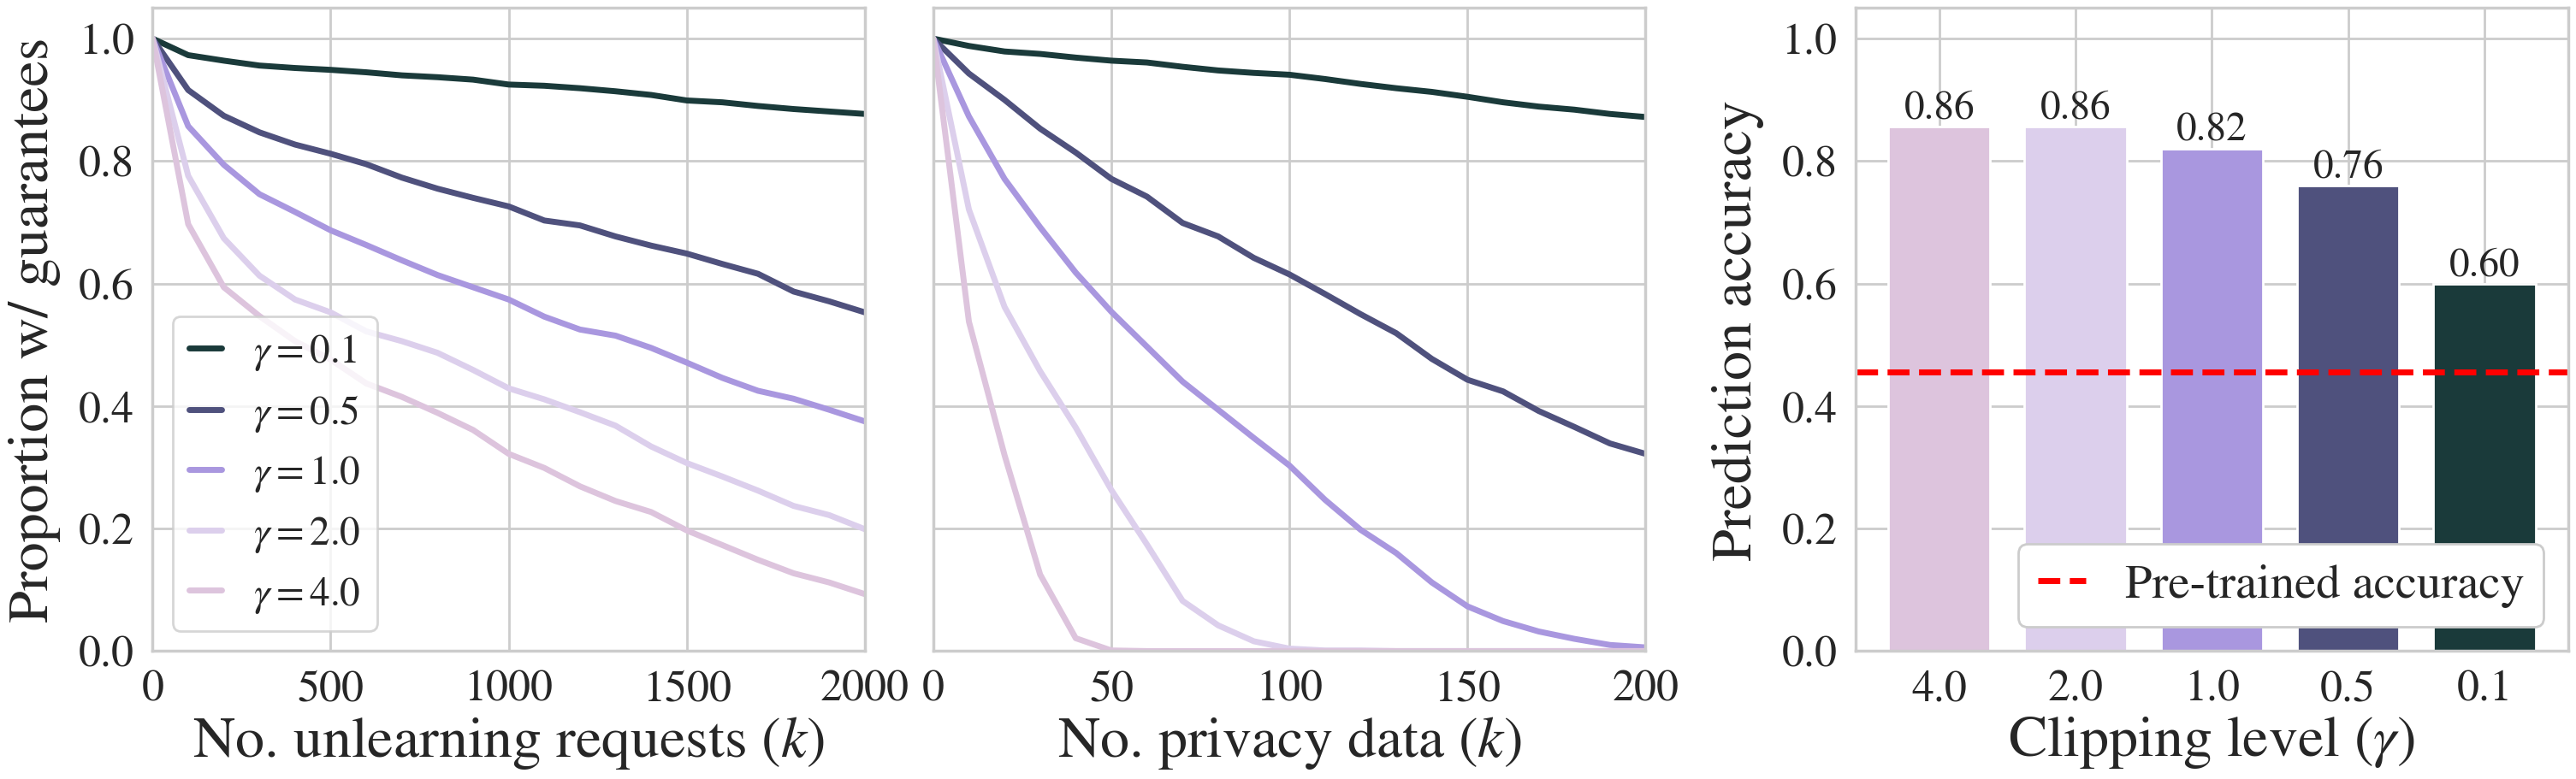

In [73]:
sns.set_theme(context="poster", style="whitegrid", font_scale=1.7)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
unlearning_palette = ["#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"][::-1]
privacy_palette = ["#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"][::-1]
fontsize = "large"

fig, axs = plt.subplots(1, 4, figsize=(30, 9), layout="constrained", width_ratios=[1, 1, 0.01, 1])

axs[2].set_visible(False)

for ax in axs:
    ax.set_ylim(0, 1.05)


colours = iter(unlearning_palette)

# first plot the percent certified
for gamma, result in unlearning_results.items():
    k_vals = list(result.keys())
    certified_percentages = [r[1] for r in result.values()]
    label = f"$\gamma = {gamma}$" if gamma != math.inf else "$\gamma = \infty$"
    axs[0].plot(k_vals, certified_percentages, color=next(colours), label=label, linewidth=5)
axs[0].set_ylabel("Proportion w/ guarantees", fontsize=fontsize, labelpad=15)
axs[0].set_xlabel("No. unlearning requests ($k$)", fontsize=fontsize)
axs[0].set_xlim(0, max(k_unlearning_vals))
axs[0].legend(loc="lower left", fontsize="small", handlelength=0.8)
axs[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

colours = iter(unlearning_palette)

for gamma, result in privacy_results.items():
    k_vals = list(result.keys())
    certified_percentages = [r[1] for r in result.values()]
    label = f"$\gamma = {gamma}$" if gamma != math.inf else "$\gamma = \infty$"
    axs[1].plot(k_vals, certified_percentages, color=next(colours), label=label, linewidth=5)
axs[1].set_xlabel("No. privacy data ($k$)", fontsize=fontsize)
# axs[1].legend(loc="lower left", fontsize="small", handlelength=0.8)
axs[1].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[1].set_xlim(0, max(k_private_vals))


axs[1].set_yticklabels([])
        
# plot the nominal accuracies on the second axis as a bar chart
bar_values = []
gamma_values = [str(g) if g != math.inf else "∞" for g in privacy_results.keys()]
bar_colors = list(reversed(list(iter(unlearning_palette))[: len(gamma_values)]))
for gamma, result in privacy_results.items():
    nominal_accs = [r[0] for r in result.values()]
    bar_values.append(nominal_accs[0])
bars = axs[3].bar(gamma_values[::-1], bar_values[::-1], color=bar_colors, width=0.75)
axs[3].axhline(pretrain_acc, label="Pre-trained accuracy", color="red", linestyle="--", lw=5)
axs[3].set_ylabel("Prediction accuracy", fontsize=fontsize, labelpad=15)
axs[3].legend(loc="lower right", fontsize="medium", framealpha=1.0, handlelength=1.0)
axs[3].set_xlabel("Clipping level ($\gamma$)", fontsize=fontsize)
    
# Add height labels to each bar
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize="small")
    
plt.savefig(".figures/oct_mnist.pdf", bbox_inches="tight", dpi=300)
    